# Retrieve and Inspect Study Level Metadata from HEAL Platform

In [1]:
import numpy as np
import pandas as pd
import altair as alt
alt.renderers.enable('svg')
from functions import get_slmd, get_heal_slmd_fields

Start with data frame containing all HEAL SLMD fields that currently appear in CEDAR.

In [2]:
df = get_slmd()
not_in_cedar = [c for c in df.columns.values.tolist() if
                c.split('.')[0] in ['citation','contacts_and_registrants','findings']]
heal_slmd = (df
    .loc[:,get_heal_slmd_fields()]
    .drop(columns=not_in_cedar)
    .applymap(lambda x: np.nan if not x else x)
)

Identify and remove those columns which are prefilled (i.e., never missing).

In [3]:
prefilled = heal_slmd.columns[heal_slmd.isna().any() == False].values.tolist()
prefilled

['minimal_info.study_name',
 'metadata_location.nih_application_id',
 'metadata_location.cedar_study_level_metadata_template_instance_ID']

In [4]:
heal_slmd = heal_slmd.drop(columns=prefilled)
heal_slmd.shape

(214, 52)

Now, examine distribution of the number of completed fields.

In [5]:
completed = heal_slmd.notna().sum(axis=1)
completed.describe()

count    214.000000
mean      13.056075
std       12.971498
min        1.000000
25%        2.000000
50%        9.000000
75%       20.000000
max       44.000000
dtype: float64

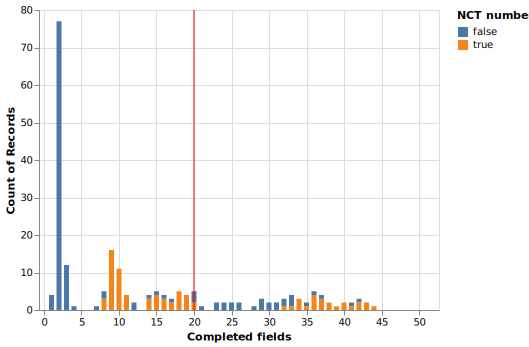

In [6]:
mydata = (pd
        .concat([completed, df['clinical_trials_id']!=''], axis=1)
        .rename(columns={0:'Completed fields','clinical_trials_id':'NCT number'})
       )
plot = alt.Chart(mydata).mark_bar().encode(
    alt.X('Completed fields:Q', scale=alt.Scale(domain=[0, 52], nice=False)),
    y='count()',
    color='NCT number:N',
    tooltip='count()'
)
line = alt.Chart().mark_rule(color='red').encode(x=alt.datum(20))
plot + line